# National and Regional impact of COVID-19 lockdown on the environement of India

### Analyzing the effect of COVID-19 and associate changes in the national and regional air quality and regional vegetation in India. 

This notebook contains the solutions to the Blue Sky Analytics DS Take-home assignment.

Submitted by - Aditya Sengupta

## COVID-19 data

Exploring the changes in the evolution of covid cases in the Indian Subcontinent (5-35N and 65-100E), which is our region of interest.

Source of the data - [WHO COVID-19 global data](https://who.int/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
%matplotlib inline

In [2]:
cov19 = pd.read_csv('./data/WHO-COVID-19-global-data.csv')
cov19_ind = cov19.loc[cov19['Country'] == "India"]

In [3]:
cov19_ind.head()

Date_reported Country_code Country WHO_region  New_cases  \
92832    2020-01-03           IN   India      SEARO          0   
92833    2020-01-04           IN   India      SEARO          0   
92834    2020-01-05           IN   India      SEARO          0   
92835    2020-01-06           IN   India      SEARO          0   
92836    2020-01-07           IN   India      SEARO          0   

       Cumulative_cases  New_deaths  Cumulative_deaths  
92832                 0           0                  0  
92833                 0           0                  0  
92834                 0           0                  0  
92835                 0           0                  0  
92836                 0           0                  0

In [13]:
# 7 day rolling mean of cases and deaths
cov19_ind['New_cases_smoothed'] = cov19_ind['New_cases'].rolling(window=7).mean() 
cov19_ind['New_deaths_smoothed'] = cov19_ind['New_deaths'].rolling(window=7).mean()

/tmp/ipykernel_264288/937387499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cov19_ind['New_cases_smoothed'] = cov19_ind['New_cases'].rolling(window=7).mean()
/tmp/ipykernel_264288/937387499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cov19_ind['New_deaths_smoothed'] = cov19_ind['New_deaths'].rolling(window=7).mean()


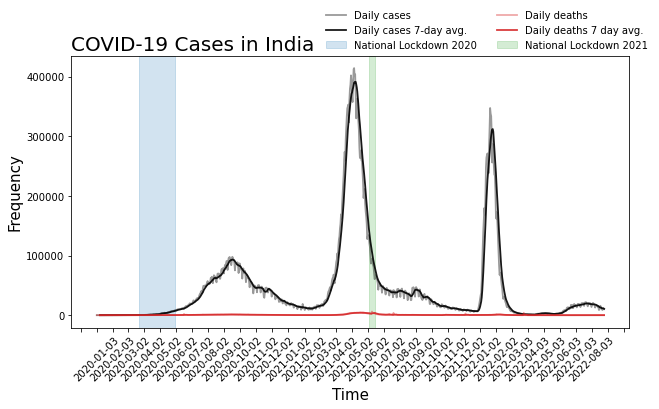

In [5]:
daily_cases = cov19_ind['New_cases'].to_numpy()
daily_deaths = cov19_ind['New_deaths'].to_numpy()
daily_cases_smoothed = cov19_ind['New_cases_smoothed'].to_numpy()
daily_deaths_smoothed = cov19_ind['New_deaths_smoothed'].to_numpy()
days = cov19_ind['Date_reported'].to_numpy()

fig = plt.figure(figsize=(10,5))
plt.plot(days, daily_cases, lw = 1.8, ls = '-', color = 'k', alpha = 0.4, label = 'Daily cases')
plt.plot(days, daily_cases_smoothed, lw = 1.8, ls = '-', color = 'k', alpha = 0.9, label = 'Daily cases 7-day avg.')
plt.axvspan(81, 149, alpha = 0.2, color='tab:blue', label = 'National Lockdown 2020')
plt.plot(days, daily_deaths, lw = 1.8, ls = '-', color = 'tab:red', alpha = 0.4, label = 'Daily deaths')
plt.plot(days, daily_deaths_smoothed, lw = 1.8, ls = '-', color = 'tab:red', alpha = 0.9, label = 'Daily deaths 7 day avg.')
plt.axvspan(519, 529, alpha = 0.2, color='tab:green', label = 'National Lockdown 2021')
plt.xticks(rotation=45);
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xlabel('Time', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('COVID-19 Cases in India', fontsize=20, loc='left')
plt.legend(frameon=False, ncol=2, loc='upper right', bbox_to_anchor = [1.05, 1.20])
plt.savefig('./images/fig1.png', dpi=300)

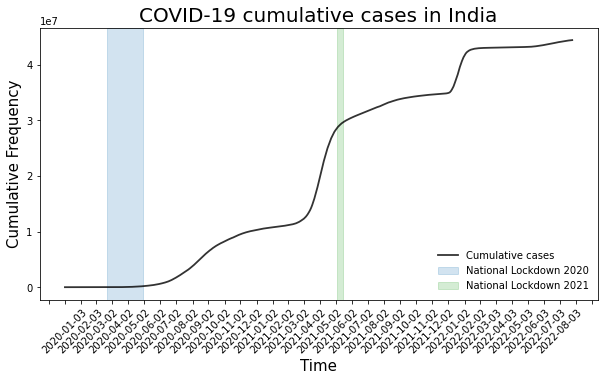

In [6]:
cumulative_cases = cov19_ind['Cumulative_cases'].to_numpy()
cumulative_deaths = cov19_ind['Cumulative_deaths'].to_numpy()
days = cov19_ind['Date_reported'].to_numpy()

fig = plt.figure(figsize=(10,5))
plt.plot(days, cumulative_cases, lw = 1.8, ls = '-', color = 'k', alpha = 0.8, label = 'Cumulative cases')
plt.axvspan(81, 149, alpha = 0.2, color='tab:blue', label = 'National Lockdown 2020')
# plt.plot(days, cumulative_deaths, lw = 1.8, ls = '-', color = 'tab:red', alpha = 0.8, label = 'Cumulative deaths')
plt.axvspan(519, 529, alpha = 0.2, color='tab:green', label = 'National Lockdown 2021')
plt.xticks(rotation=45);
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xlabel('Time', fontsize=15)
plt.ylabel('Cumulative Frequency', fontsize=15)
plt.title('COVID-19 cumulative cases in India', fontsize=20, loc='center')
plt.legend(frameon=False, ncol=1, loc='lower right')
plt.savefig('./images/fig2.png', dpi=300)

## Air Quality

### Analysing the variations in Aerosol Optical Depth

Here the changes in AOD are analysed and to visualise the affect of CoVID lockdown on Aerosol content in the atmosphere in the Indian subcontinent which is a good proxy for pollutant concentrations. 

Souce of the data -> Level-1 and Atmosphere Archive & Distribution System Distributed Active Archive Center or [LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/). 

The data is based on the retreivals from the VIIRS instrument onboard the SNPP | JPSS-1 satellite and is a radiometer.

In [2]:
# importing the necessary libraries for geospatial analysis

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import dask

I want to import the data in bulk but each file does not contain the `time` dimension, so, it is added manually to each file using the following function in the `preprocess` argument of xarray's `open_mfdataset function`. And then I replace the manual dates with the dates of the actual files

In [3]:
def add_time_dim(xda):
    xda = xda.expand_dims(time = [dt.date.today()])
    return xda

In [5]:
ds = xr.open_mfdataset('./data/AOD/*.nc', engine='netcdf4', preprocess=add_time_dim, combine='nested', concat_dim='time')

In [6]:
ds

<xarray.Dataset>
Dimensions:                                                      (time: 2557, Latitude_1D: 180, Longitude_1D: 360, Aerosol_Types: 8, Land_Bands: 3, Ocean_Bands: 7)
Coordinates:
  * time                                                         (time) object ...
  * Aerosol_Types                                                (Aerosol_Types) int32 ...
  * Land_Bands                                                   (Land_Bands) float32 ...
    Latitude                                                     (Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * Latitude_1D                                                  (Latitude_1D) float32 ...
    Longitude                                                    (Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * Longitude_1D                                                 (Longitude_1D) float32 ...
  * Ocean_Bands                                                  (Ocean_Bands) float32 ...
Data variables: (12/37)
    Aerosol_Optical_Thickness_550_Land_Count                     (time, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Maximum                   (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Mean                      (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Minimum                   (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Ocean_Count               (time, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Ocean_Maximum             (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                                                           ...
    Spectral_Aerosol_Optical_Thickness_Land_Count                (time, Land_Bands, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 3, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Land_Mean                 (time, Land_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 3, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Land_Standard_Deviation   (time, Land_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 3, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Ocean_Count               (time, Ocean_Bands, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 7, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Ocean_Mean                (time, Ocean_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 7, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Ocean_Standard_Deviation  (time, Ocean_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 7, 180, 360), meta=np.ndarray>
Attributes: (12/58)
    description:                       VIIRS Deep Blue Level 3 daily aerosol ...
    comment:                           Data are the arithmetic mean of all VI...
    references:                        https://deepblue.gsfc.nasa.gov
    institution:                       NASA Goddard Space Flight Center
    production_datetime:               2021-04-09T14:31:13Z
    geospatial_lat_max:                90.0
    ...                                ...
    creator_institution:               Space Science & Engineering Center, Un...
    publisher_name:                    LAADS
    publisher_url:                     https://ladsweb.modaps.eosdis.nasa.gov/
    publisher_email:                   modis-ops@lists.nasa.gov
    publisher_institution:             NASA Level-1 and Atmosphere Archive & ...
    xmlmetadata:                      

The data is obtained for the time period of 2015-2021. the purpose of downloading the long term data was to do a anomaly analysis of the yeas 2019 (pre-covid) and 2020 (post-covid) against the long term 2015-2021 mean

In [7]:
dates = pd.date_range(start = '2015-01-01', end = '2021-12-31', freq='1D')
dates

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=2557, freq='D')

In [8]:
ds['time'] = dates

In [9]:
ds

<xarray.Dataset>
Dimensions:                                                      (time: 2557, Latitude_1D: 180, Longitude_1D: 360, Aerosol_Types: 8, Land_Bands: 3, Ocean_Bands: 7)
Coordinates:
  * time                                                         (time) datetime64[ns] ...
  * Aerosol_Types                                                (Aerosol_Types) int32 ...
  * Land_Bands                                                   (Land_Bands) float32 ...
    Latitude                                                     (Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * Latitude_1D                                                  (Latitude_1D) float32 ...
    Longitude                                                    (Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * Longitude_1D                                                 (Longitude_1D) float32 ...
  * Ocean_Bands                                                  (Ocean_Bands) float32 ...
Data variables: (12/37)
    Aerosol_Optical_Thickness_550_Land_Count                     (time, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Maximum                   (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Mean                      (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Minimum                   (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Ocean_Count               (time, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Aerosol_Optical_Thickness_550_Land_Ocean_Maximum             (time, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                                                           ...
    Spectral_Aerosol_Optical_Thickness_Land_Count                (time, Land_Bands, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 3, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Land_Mean                 (time, Land_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 3, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Land_Standard_Deviation   (time, Land_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 3, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Ocean_Count               (time, Ocean_Bands, Latitude_1D, Longitude_1D) float64 dask.array<chunksize=(1, 7, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Ocean_Mean                (time, Ocean_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 7, 180, 360), meta=np.ndarray>
    Spectral_Aerosol_Optical_Thickness_Ocean_Standard_Deviation  (time, Ocean_Bands, Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(1, 7, 180, 360), meta=np.ndarray>
Attributes: (12/58)
    description:                       VIIRS Deep Blue Level 3 daily aerosol ...
    comment:                           Data are the arithmetic mean of all VI...
    references:                        https://deepblue.gsfc.nasa.gov
    institution:                       NASA Goddard Space Flight Center
    production_datetime:               2021-04-09T14:31:13Z
    geospatial_lat_max:                90.0
    ...                                ...
    creator_institution:               Space Science & Engineering Center, Un...
    publisher_name:                    LAADS
    publisher_url:                     https://ladsweb.modaps.eosdis.nasa.gov/
    publisher_email:                   modis-ops@lists.nasa.gov
    publisher_institution:             NASA Level-1 and Atmosphere Archive & ...
    xmlmetadata:              

Obtaining the data for the indian region - 

In [10]:
aod_ind = ds.Aerosol_Optical_Thickness_550_Land_Mean.sel(Latitude_1D = slice(5,35), Longitude_1D = slice(65,100))
aod_ind

<xarray.DataArray 'Aerosol_Optical_Thickness_550_Land_Mean' (time: 2557, Latitude_1D: 30, Longitude_1D: 35)>
dask.array<getitem, shape=(2557, 30, 35), dtype=float32, chunksize=(1, 30, 35), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    Latitude      (Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(30, 35), meta=np.ndarray>
  * Latitude_1D   (Latitude_1D) float32 5.5 6.5 7.5 8.5 ... 31.5 32.5 33.5 34.5
    Longitude     (Latitude_1D, Longitude_1D) float32 dask.array<chunksize=(30, 35), meta=np.ndarray>
  * Longitude_1D  (Longitude_1D) float32 65.5 66.5 67.5 68.5 ... 97.5 98.5 99.5
Attributes:
    long_name:    aerosol optical thickness estimated at 550 nm over land
    units:        1
    valid_range:  [ 0. 10.]

In [4]:
# plotting function
ind_extent = [65.1, 99.9, 5.1, 34.9]
def plot_background(ax, extent=ind_extent):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # ax.add_feature(ind_coastline, alpha=0.5, lw=1.0)
    ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=1.0)
    # ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='lightgray')
    gridliner = ax.gridlines(draw_labels=True, linewidth=1.0, color="gray", linestyle="--", alpha=0.5)
    gridliner.top_labels=False
    gridliner.right_labels=False
    gridliner.xlines=False
    gridliner.ylines=False
    # Set the map bounds
    # ax.set_xlim(cartopy_xlim(test1))
    # ax.set_ylim(cartopy_ylim(test1))
    return ax

Calculating the 2015-2021 mean

In [12]:
mean_pentad_aod = aod_ind.mean(dim='time').to_numpy()

In [13]:
x, y = np.meshgrid(aod_ind.coords['Longitude_1D'], aod_ind.coords['Latitude_1D'])

In [5]:
from matplotlib.colors import BoundaryNorm as BM
import matplotlib as m

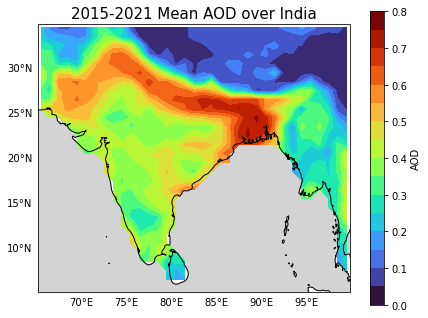

In [14]:
levels = np.arange(0, 0.85, 0.05)
fig, ax = plt.subplots(1,1, figsize=(7,6), subplot_kw={'projection':ccrs.PlateCarree()})
cf = ax.contourf(x, y, mean_pentad_aod, cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree())
plot_background(ax)
norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='turbo'), ax = ax, \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.05, label = 'AOD')
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)
plt.title('2015-2021 Mean AOD over India', fontsize=15)
plt.savefig('./images/fig3.png', dpi=300)

Extracting the MAM months from 2019 and 2020

In [15]:
def is_mam(month):
    return (month >= 3) & (month <= 5)
aod_ind_2019 = aod_ind.sel(time = aod_ind['time.year'] == 2019)
aod_ind_2019_mam = aod_ind_2019.sel(time = is_mam(aod_ind_2019['time.month']))

aod_ind_2020 = aod_ind.sel(time = aod_ind['time.year'] == 2020)
aod_ind_2020_mam = aod_ind_2020.sel(time = is_mam(aod_ind_2020['time.month']))

Plotting the MAM 2019 and 2020 AOD mean values and difference in them

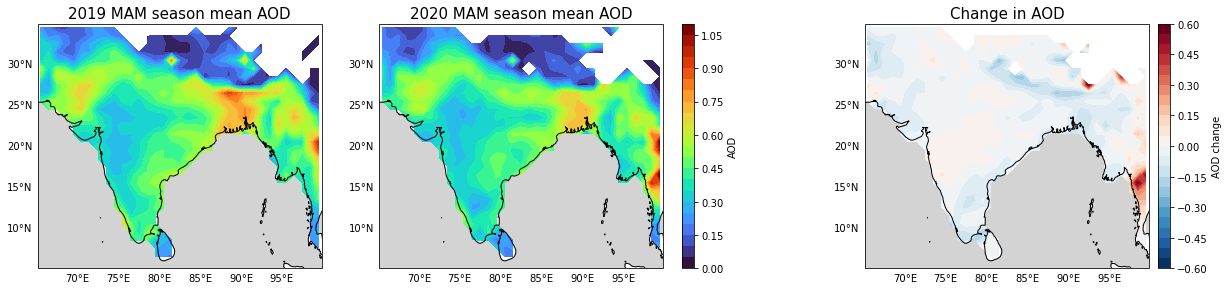

In [33]:
levels = np.arange(0, 1.15, 0.05)
fig, axarr = plt.subplots(1,3, figsize=(21,5), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, aod_ind_2019_mam.mean(dim='time').to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree())
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season mean AOD', fontsize=15)

cf1 = axlist[1].contourf(x, y, aod_ind_2020_mam.mean(dim='time').to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree())
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season mean AOD', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='turbo'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'AOD')


levels = np.arange(-0.6, 0.65, 0.05)
cf2 = axlist[2].contourf(x, y, aod_ind_2020_mam.mean(dim='time').to_numpy() - aod_ind_2019_mam.mean(dim='time').to_numpy(), cmap = 'RdBu_r', levels = levels, transform = ccrs.PlateCarree())
# axlist[2].set_xlabel('Longitude', fontsize=13)
# axlist[2].set_ylabel('Latitude', fontsize=13)
axlist[2].set_title('Change in AOD', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='RdBu_r'), ax = axlist[2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'AOD change')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig4.png', dpi=300)

Plotting the anomaly of 2019 MAM and 2020 MAM season against the long term (2015-2021) mean. 

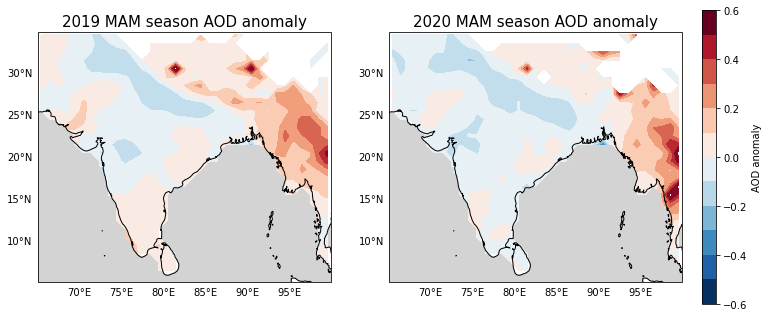

In [17]:
levels = np.arange(-0.6, 0.7, 0.1)
fig, axarr = plt.subplots(1,2, figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, aod_ind_2019_mam.mean(dim='time').to_numpy() - mean_pentad_aod, cmap = 'RdBu_r', levels = levels, transform = ccrs.PlateCarree())
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season AOD anomaly', fontsize=15)

cf1 = axlist[1].contourf(x, y, aod_ind_2020_mam.mean(dim='time').to_numpy() - mean_pentad_aod, cmap = 'RdBu_r', levels = levels, transform = ccrs.PlateCarree())
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season AOD anomaly', fontsize=15)


norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='RdBu_r'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'AOD anomaly')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig5.png', dpi=300)

Analysing the time series analysis for the year 2018 and 2019 (pre-covid) and 2020 (post-covid) and associate kernel density distrbutions

In [16]:
aod_ind_time_series = aod_ind.mean(dim = ['Latitude_1D', 'Longitude_1D'])

In [17]:
aod_ind_time_series_2018 = aod_ind_time_series.sel(time = aod_ind_time_series['time.year'] == 2018)
aod_ind_time_series_2019 = aod_ind_time_series.sel(time = aod_ind_time_series['time.year'] == 2019)
aod_ind_time_series_2020 = aod_ind_time_series.sel(time = aod_ind_time_series['time.year'] == 2020)
aod_ind_time_series_2020_mam = aod_ind_time_series_2020.sel(time = is_mam(aod_ind_time_series_2020['time.month']))

In [18]:
import seaborn as sns

Text(0.5, 1.0, 'Kernel Density Estimate')

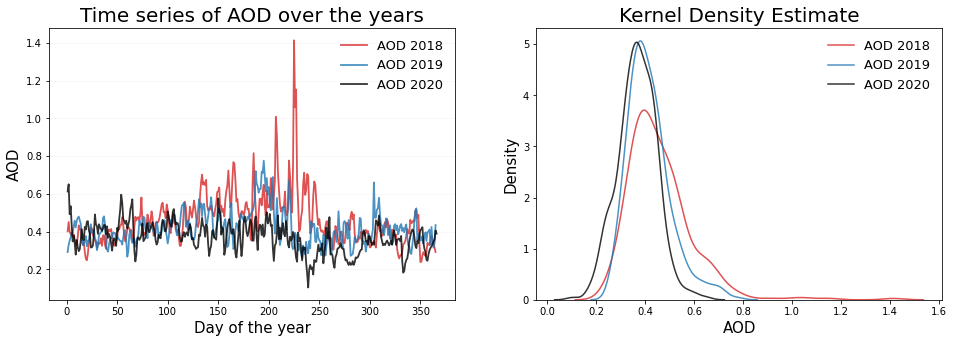

In [19]:
fig = plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(np.arange(1, 366, 1), aod_ind_time_series_2018, lw=1.8, color='tab:red', alpha = 0.8, label='AOD 2018')
plt.plot(np.arange(1, 366, 1), aod_ind_time_series_2019, lw=1.8, color='tab:blue', alpha = 0.8, label = 'AOD 2019')
plt.plot(np.arange(1, 367, 1), aod_ind_time_series_2020, lw=1.8, ls='-', color='k', alpha = 0.8, label = 'AOD 2020')
plt.xlabel('Day of the year', fontsize=15)
plt.ylabel('AOD', fontsize=15)
plt.legend(frameon = False, ncol=1, fontsize=13)
plt.title('Time series of AOD over the years', fontsize=20)
plt.grid(axis='y', alpha = 0.1)

plt.subplot(122)
sns.kdeplot(aod_ind_time_series_2018, lw = 1.5, color='tab:red', label = 'AOD 2018', alpha = 0.8)
sns.kdeplot(aod_ind_time_series_2019, lw = 1.5, color='tab:blue', label = 'AOD 2019', alpha = 0.8)
sns.kdeplot(aod_ind_time_series_2020, lw = 1.5, ls='-', color='k', label = 'AOD 2020', alpha = 0.8)
plt.xlabel('AOD', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(frameon = False, ncol=1, fontsize=13)
plt.title('Kernel Density Estimate', fontsize=20)
# plt.savefig('./images/fig6.png', dpi=300)

**It is evident from the analysis of AOD retrievals that the post-covid year of 2020 and the lockdown period has been associated with lower AQI when compared with the AOD values of pre-covid years, be it 2019 or 2020**

**To further confirm that this reduction in the AQI of the 3 sample years is not by change, a non-parametric Friedman's Chi square test is employed on the three annual AOD samples of 2018, 2019 and 2020 -**

In [20]:
from scipy import stats

In [22]:
F, p = stats.friedmanchisquare(aod_ind_time_series_2018, aod_ind_time_series_2019, aod_ind_time_series_2020[:-1])
p

2.623809645595713e-25

**The p-value << 0.001** indicating rejecting the hypothesis that this change in AOD variability is by chance and is statistically significant. The Friedman' test is similar to ANOVA test but it is advantageous in the sense that it is non-parametric and doesn't assume any particular distribution of the samples beforehand.

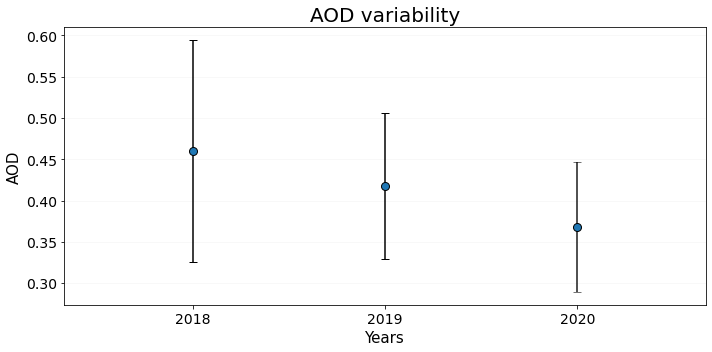

In [29]:
aod_ind_2018_mean = np.mean(aod_ind_time_series_2018)
aod_ind_2018_std = np.std(aod_ind_time_series_2018)

aod_ind_2019_mean = np.mean(aod_ind_time_series_2019)
aod_ind_2019_std = np.std(aod_ind_time_series_2019)

aod_ind_2020_mean = np.mean(aod_ind_time_series_2020)
aod_ind_2020_std = np.std(aod_ind_time_series_2020)

fig = plt.figure(figsize=(10,5))
(markers, caps, bars) = plt.errorbar(1, aod_ind_2018_mean, yerr=aod_ind_2018_std, alpha=1.0, color='k', fmt='o', mfc='tab:blue', ms = 8, capsize=4)

(markers, caps, bars) = plt.errorbar(4, aod_ind_2019_mean, yerr=aod_ind_2019_std, alpha=1.0, color='k', fmt='o', mfc='tab:blue', ms = 8, capsize=4)

(markers, caps, bars) = plt.errorbar(7, aod_ind_2020_mean, yerr=aod_ind_2020_std, alpha=1.0, color='k', fmt='o', mfc='tab:blue', ms = 8, capsize=4)

# (markers, caps, bars) = plt.errorbar(120, precip_postmon_mean, yerr=precip_postmon_std, alpha=1.0, color='k', fmt='o', mfc='k', ms = 8, capsize=4, label = 'Precip')
# (markers, caps, bars) = plt.errorbar(120, pe_postmon_mean, yerr=pe_postmon_std, alpha=1.0, color='k', fmt='^', mfc='k', ms = 8, capsize=4, label = 'Pe')
# (markers, caps, bars) = plt.errorbar(120, dyn_postmon_mean, yerr=dyn_postmon_std, alpha=1.0, color='k', fmt='s', mfc='k', ms = 8, capsize=4, label = 'Dyn')
# (markers, caps, bars) = plt.errorbar(120, thermo_postmon_mean, yerr=thermo_postmon_std, alpha=1.0, color='k', fmt='D', mfc='k', ms = 8, capsize=4, label = 'Thermo')

for cap in caps:
    cap.set_markeredgewidth(0.6)
    cap.set_alpha(0.9)
for bar in bars:
    bar.set_alpha(0.9)
    
plt.yticks(fontsize=14)
plt.xticks([1.0, 4.0, 7.0], fontsize=14)
plt.gca().set_xticklabels(['2018', '2019', '2020'])
plt.xlim(-1, 9)
plt.xlabel('Years', fontsize=15)
plt.ylabel('AOD', fontsize=15)
# plt.legend(frameon = False, ncol=4, fontsize=14, bbox_to_anchor = [0.98, 1.12], loc='upper right')
plt.grid(axis='y', alpha=0.1)
plt.title('AOD variability', fontsize = 20)
plt.tight_layout()
# plt.savefig('./images2/contribution_season24.pdf', dpi=300)
# plt.savefig('./images2/contribution_season24.png', dpi=300)

### A similar analysis if further carried out for individual pollutants of CO, HCHO and NO2

The Source of the data is from the TROPOMI satellite retrievals which have been preprocessed and available at [TROPOMI QA$ECV](http://www.qa4ecv.eu/ecvs). The CO and HCHO data were available in netcdf formats but the NO2 data was in ESRI grid format for download as monthly means.

#### CO

In [20]:
ds = xr.open_mfdataset('./data/TROPOMI_columns/CO/*.nc', preprocess=add_time_dim, concat_dim='time', combine='nested')

In [21]:
ds['time'] = pd.date_range(start = '2015-01-01', end = '2022-01-01', freq='1M')
ds = ds.transpose('time', 'latitude', 'longitude')
ds

<xarray.Dataset>
Dimensions:         (time: 84, latitude: 180, longitude: 360)
Coordinates:
  * time            (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2021-12-31
  * latitude        (latitude) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude       (longitude) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    COgridDAY       (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    COgridNIGHT     (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ErrorgridDAY    (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ErrorgridNIGHT  (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/32)
    title:                                   Monthly IASI/Metop-B ULB-LATMOS ...
    institution:                             LATMOS
    product_version:                         20151001.0
    history:                                 2020-11-18 22:57:04 - Product ge...
    summary:                                 This dataset contains Level 3 ca...
    source:                                  ULB-LATMOS IASI Level 2 carbon m...
    ...                                      ...
    sensor:                                  IASI
    spatial_resolution:                      grid: 1 deg x 1 deg
    creator_type:                            institution
    creator_name:                            LATMOS
    contact_email:                           contact form at http://iasi.aeri...
    data_policy:                             see https://iasi.aeris-data.fr/d...

In [22]:
co_ind = ds.COgridDAY.sel(latitude = slice(5,35), longitude = slice(65,100))
co_ind

<xarray.DataArray 'COgridDAY' (time: 84, latitude: 30, longitude: 35)>
dask.array<getitem, shape=(84, 30, 35), dtype=float32, chunksize=(1, 30, 35), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2021-12-31
  * latitude   (latitude) float32 5.5 6.5 7.5 8.5 9.5 ... 31.5 32.5 33.5 34.5
  * longitude  (longitude) float32 65.5 66.5 67.5 68.5 ... 96.5 97.5 98.5 99.5
Attributes:
    long_name:                                             weighted average o...
    units:                                                 mol m-2
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214179e+19
    vertical_range_bottom:                                 surface
    vertical_range_top:                                    60.0_km
    comment:                                               daytime observatio...

In [23]:
x, y = np.meshgrid(co_ind.coords['longitude'], co_ind.coords['latitude'])

In [24]:
co_ind_2019 = co_ind.sel(time = co_ind['time.year'] == 2019)
co_ind_2019_mam = co_ind_2019.sel(time = is_mam(co_ind_2019['time.month']))

co_ind_2020 = co_ind.sel(time = co_ind['time.year'] == 2020)
co_ind_2020_mam = co_ind_2020.sel(time = is_mam(co_ind_2020['time.month']))

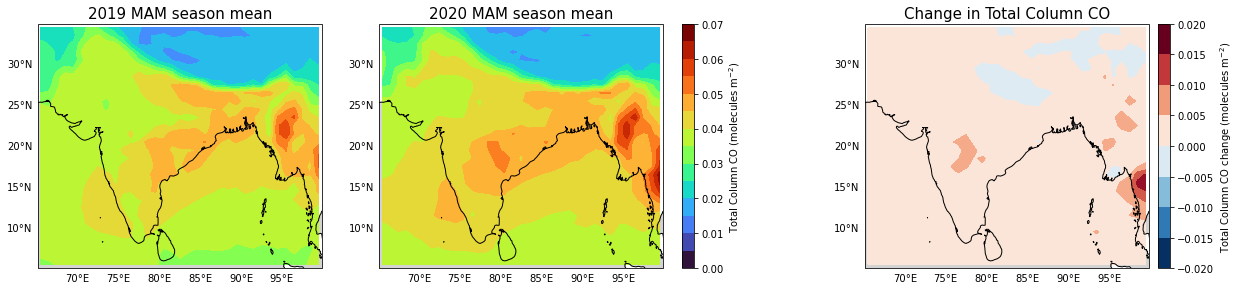

In [25]:
levels = np.arange(0, 0.070, 0.005)
fig, axarr = plt.subplots(1,3, figsize=(21,5), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, co_ind_2019_mam.mean(dim='time').to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree())
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season mean', fontsize=15)

cf1 = axlist[1].contourf(x, y, co_ind_2020_mam.mean(dim='time').to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree())
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season mean', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='turbo'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Total Column CO (molecules m$^{-2}$)')


levels = np.arange(-0.02, 0.025, 0.005)
cf2 = axlist[2].contourf(x, y, co_ind_2020_mam.mean(dim='time').to_numpy() - co_ind_2019_mam.mean(dim='time').to_numpy(), cmap = 'RdBu_r', levels = levels, transform = ccrs.PlateCarree())
# axlist[2].set_xlabel('Longitude', fontsize=13)
# axlist[2].set_ylabel('Latitude', fontsize=13)
axlist[2].set_title('Change in Total Column CO', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='RdBu_r'), ax = axlist[2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Total Column CO change (molecules m$^{-2}$)')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig7.png', dpi=300)

#### HCHO

In [8]:
ds = xr.open_mfdataset('./data/TROPOMI_columns/HCHO/*.nc', preprocess=add_time_dim, concat_dim='time', combine='nested')

In [9]:
ds_ind = ds.HCHO_VCD.sel(latitude = slice(5,35), longitude = slice(65,100))
ds_ind

<xarray.DataArray 'HCHO_VCD' (time: 6, latitude: 600, longitude: 700)>
dask.array<getitem, shape=(6, 600, 700), dtype=float32, chunksize=(1, 600, 700), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2022-08-31 2022-08-31 ... 2022-08-31 2022-08-31
  * latitude   (latitude) float32 5.025 5.075 5.125 5.175 ... 34.88 34.92 34.97
  * longitude  (longitude) float32 65.03 65.07 65.12 65.18 ... 99.88 99.93 99.97
Attributes:
    long_name:     Mean formaldehyde tropospheric column
    units:         molecules cm-2
    grid_mapping:  projection

In [10]:
hcho_2019_mam = ds_ind.isel(time = slice(0,3))
hcho_2020_mam = ds_ind.isel(time = slice(3,6))

In [11]:
hcho_2019_mam['time'] = pd.date_range('2019-03-01', '2019-06-01', freq='1M')
hcho_2020_mam['time'] = pd.date_range('2020-03-01', '2020-06-01', freq='1M')

In [12]:
# hcho_2019_mam
hcho_2020_mam

<xarray.DataArray 'HCHO_VCD' (time: 3, latitude: 600, longitude: 700)>
dask.array<getitem, shape=(3, 600, 700), dtype=float32, chunksize=(1, 600, 700), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-03-31 2020-04-30 2020-05-31
  * latitude   (latitude) float32 5.025 5.075 5.125 5.175 ... 34.88 34.92 34.97
  * longitude  (longitude) float32 65.03 65.07 65.12 65.18 ... 99.88 99.93 99.97
Attributes:
    long_name:     Mean formaldehyde tropospheric column
    units:         molecules cm-2
    grid_mapping:  projection

In [27]:
x, y = np.meshgrid(hcho_2019_mam.coords['longitude'], hcho_2019_mam.coords['latitude'])

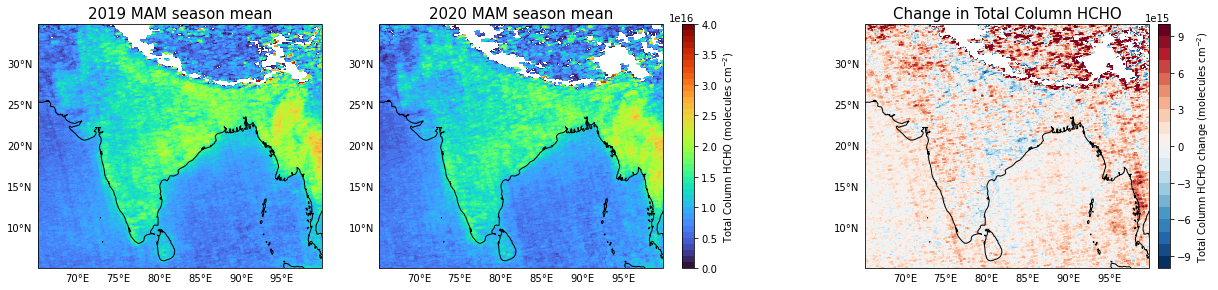

In [37]:
levels = np.arange(0, 4.1, 0.1)*10**16
fig, axarr = plt.subplots(1,3, figsize=(21,5), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, hcho_2019_mam.mean(dim='time').to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree())
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season mean', fontsize=15)

cf1 = axlist[1].contourf(x, y, hcho_2020_mam.mean(dim='time').to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree())
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season mean', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='turbo'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Total Column HCHO (molecules cm$^{-2}$)')


levels = np.arange(-1, 1.1, 0.1)*10**16
cf2 = axlist[2].contourf(x, y, hcho_2020_mam.mean(dim='time').to_numpy() - hcho_2019_mam.mean(dim='time').to_numpy(), cmap = 'RdBu_r', levels = levels, transform = ccrs.PlateCarree())
# axlist[2].set_xlabel('Longitude', fontsize=13)
# axlist[2].set_ylabel('Latitude', fontsize=13)
axlist[2].set_title('Change in Total Column HCHO', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='RdBu_r'), ax = axlist[2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Total Column HCHO change (molecules cm$^{-2}$)')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig8.png', dpi=300)

#### NO2

In [60]:
def read_grd(filename):
    with open(filename) as infile:
        ncols = int(infile.readline().split()[1])
        nrows = int(infile.readline().split()[1])
        xllcorner = float(infile.readline().split()[1])
        yllcorner = float(infile.readline().split()[1])
        cellsize = float(infile.readline().split()[1])
        nodata_value = int(infile.readline().split()[1])
        version = float(infile.readline().split()[1])
    longitude = xllcorner + cellsize * np.arange(ncols)
    latitude = (xllcorner + cellsize * np.arange(nrows) + 90)[::-1]
    value = np.loadtxt(filename, skiprows=7)
    da = xr.DataArray(data = value, dims = ["lat", "lon"], coords = dict(lon = (["lon"], longitude), lat = (["lat"], latitude)))

    # return longitude, latitude, value
    return da

In [61]:
no2_201903 = read_grd('./data/TROPOMI_columns/NO2/no2_201903.grd')
no2_201904 = read_grd('./data/TROPOMI_columns/NO2/no2_201904.grd')
no2_201905 = read_grd('./data/TROPOMI_columns/NO2/no2_201905.grd')
no2_202003 = read_grd('./data/TROPOMI_columns/NO2/no2_202003.grd')
no2_202004 = read_grd('./data/TROPOMI_columns/NO2/no2_202004.grd')
no2_202005 = read_grd('./data/TROPOMI_columns/NO2/no2_202005.grd')

In [62]:
no2_2019_mam = (no2_201903 + no2_201904 + no2_201905)/3
no2_2020_mam = (no2_202003 + no2_202004 + no2_202005)/3

In [41]:
# long_ind, lat_ind = long[np.where(long == 65)[0][0]:np.where(long == 100)[0][0]], lat[np.where(lat == 5)[0][0]:np.where(lat == 35)[0][0]]

In [47]:
# no2_2019_mam_ind = no2_2019_mam[np.where(lat == 5)[0][0]:np.where(lat == 35)[0][0], np.where(long == 65)[0][0]:np.where(long == 100)[0][0]]
# no2_2020_mam_ind = no2_2020_mam[np.where(lat == 5)[0][0]:np.where(lat == 35)[0][0], np.where(long == 65)[0][0]:np.where(long == 100)[0][0]]

In [77]:
no2_2019_mam_ind = no2_2019_mam.sel(lat = slice(35, 5), lon = slice(65, 100))/100
no2_2020_mam_ind = no2_2020_mam.sel(lat = slice(35, 5), lon = slice(65, 100))/100
no2_2020_mam_ind

<xarray.DataArray (lat: 241, lon: 281)>
array([[ 0.30333333,  0.34333333,  0.33      , ..., -0.23666667,
        -0.15666667, -0.05333333],
       [ 0.24666667,  0.53666667,  0.60333333, ..., -0.07333333,
         0.04      ,  0.04      ],
       [ 0.16333333,  0.37666667,  0.41      , ...,  0.23666667,
         0.44333333,  0.44333333],
       ...,
       [ 0.46666667,  0.5       ,  0.61333333, ...,  1.16      ,
         1.36666667,  1.68666667],
       [ 0.3       ,  0.33      ,  0.56      , ...,  1.17333333,
         1.40333333,  1.69      ],
       [ 0.25333333,  0.31      ,  0.39666667, ...,  1.14333333,
         1.32333333,  1.48666667]])
Coordinates:
  * lon      (lon) float64 65.0 65.12 65.25 65.38 ... 99.62 99.75 99.88 100.0
  * lat      (lat) float64 35.0 34.88 34.75 34.62 34.5 ... 5.375 5.25 5.125 5.0

In [84]:
x, y = np.meshgrid(no2_2019_mam_ind.coords['lon'], no2_2019_mam_ind.coords['lat'])

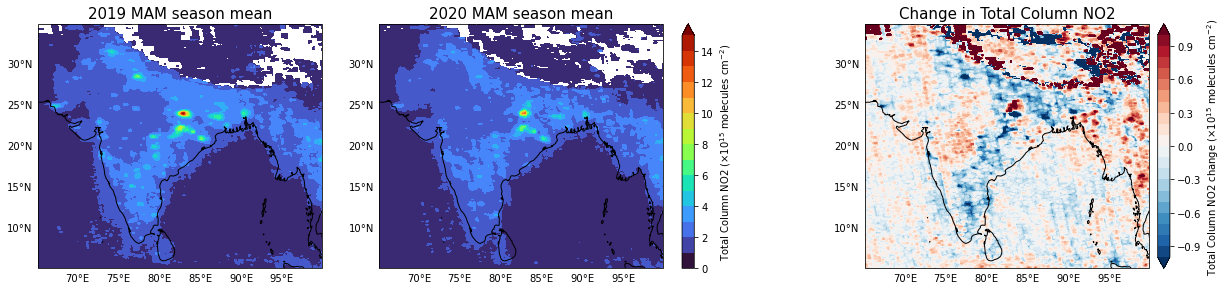

In [94]:
levels = np.arange(0, 16, 1)
fig, axarr = plt.subplots(1,3, figsize=(21,5), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, no2_2019_mam_ind.to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree(), extend='max')
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season mean', fontsize=15)

cf1 = axlist[1].contourf(x, y, no2_2020_mam_ind.to_numpy(), cmap = 'turbo', levels = levels, transform = ccrs.PlateCarree(), extend='max')
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season mean', fontsize=15)

norm = BM(levels, 256, extend = 'max')
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='turbo'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = r'Total Column NO2 ($\times 10^{15}$ molecules cm$^{-2}$)')


levels = np.arange(-1, 1.1, 0.1)
cf2 = axlist[2].contourf(x, y, no2_2020_mam_ind.to_numpy() - no2_2019_mam_ind.to_numpy(), cmap = 'RdBu_r', levels = levels, transform = ccrs.PlateCarree(), extend='both')
# axlist[2].set_xlabel('Longitude', fontsize=13)
# axlist[2].set_ylabel('Latitude', fontsize=13)
axlist[2].set_title('Change in Total Column NO2', fontsize=15)

norm = BM(levels, 256, extend = 'both')
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='RdBu_r'), ax = axlist[2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = r'Total Column NO2 change ($\times 10^{15}$ molecules cm$^{-2}$)')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig9.png', dpi=300)

**It can be concluded here that the concentrations of tropospheric column CO have marginally increased while the changes in HCHO concentrations are not clearly significant. But for NO2 there is a significant reduction in the concentrations especially in the Southern Indian Peninsula and the Indo-Gangetic Plain.**

#### Using Google Earth Engine, a similar analysis to compare the 2019 and 2020 concentrations of NO2, SO2 and Aerosol Index with the TROPOMI Sentinel-5P product is done.

In [9]:
import geemap.eefolium as geemap
import ee

In [10]:
# ee.Authenticate()
# ee.Initialize()

In [11]:
Map = geemap.Map(center= [23.634,77.814], zoom = 4.0)
# Map2 = geemap.Map(center= [23.634,77.814], zoom = 4.0)
# Map.setOptions('HYBRID')

In [12]:
aerosol_uv_2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_AER_AI').select('absorbing_aerosol_index').filterDate('2019-03-01', '2019-05-31');
aerosol_uv_2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_AER_AI').select('absorbing_aerosol_index').filterDate('2020-03-01', '2020-05-31');

band_viz = {
  'min': -1,
  'max': 2.0,
  'opacity':0.75,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
};

Map.addLayer(aerosol_uv_2019.mean(), band_viz, 'S5P Aerosol 2019');
Map.addLayer(aerosol_uv_2020.mean(), band_viz, 'S5P Aerosol 2020');
# Map.setCenter(-118.82, 36.1, 5);

In [13]:
no2_2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2019-03-01', '2019-05-31');
no2_2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2020-03-01', '2020-05-31');

band_viz2 = {
  'min': 0,
  'max': 0.0002,
  'opacity': 0.75,
  # 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
  'palette': ['black', 'purple', 'orange', 'yellow']
};

Map.addLayer(no2_2019.mean(), band_viz2, 'S5P N02 2019');
Map.addLayer(no2_2020.mean(), band_viz2, 'S5P N02 2020');

In [14]:
so2_2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').select('SO2_column_number_density').filterDate('2019-03-01', '2019-05-31');
so2_2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_SO2').select('SO2_column_number_density').filterDate('2020-03-01', '2020-05-31');

band_viz = {
  'min': 0.0,
  'max': 0.0005,
  'opacity': 0.75,
  # 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
  'palette': ['white', 'yellow', 'orange', 'red', 'black']
};

Map.addLayer(so2_2019.mean(), band_viz, 'S5P SO2 2019');
Map.addLayer(so2_2020.mean(), band_viz, 'S5P SO2 2020');

In [15]:
Map

## Water Quality

#### Water quality was analysed using the Google Earth engine and Sentinel-2 MSI : MultiSpectral Instrument, Level-2A bands to calculate the value of Normalised Difference Chlorophyll Index (NDCI), which varies between -1 and 1 and higher the value, higher is the turbidity and poor is the quality of water

The analysis is done for Ganges in the Bhagalpur region for pre-lockdown (March 2019) and post-lockdown (April-May 2019) period.

In [2]:
Map = geemap.Map(center= [25.543,86.953], zoom = 8.5)

In [3]:
region = ee.Geometry.Polygon(
    [[[86.92, 25.45],
    [86.92, 25.05],
    [87.13, 25.05],
    [87.13, 25.45]]]);

In [4]:
img_prelock = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(region).filterDate('2019-03-01', '2019-03-31').sort('CLOUDY_PIXEL_PERCENTAGE',True).first().clip(region);
img_postlock = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(region).filterDate('2020-04-01', '2020-05-31').sort('CLOUDY_PIXEL_PERCENTAGE',True).first().clip(region);

In [5]:
def ndwi_f(img): 
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI');
    return img.addBands(ndwi).updateMask(ndwi.gt(0))

def ndci_f(img):
    ndci = img.normalizedDifference(['B5', 'B4']).rename('NDCI');
    return img.addBands(ndci)

In [6]:
img_water_prelock = ndwi_f(img_prelock)
img_ndci_prelock = ndci_f(img_water_prelock)

img_water_postlock = ndwi_f(img_postlock)
img_ndci_postlock = ndci_f(img_water_postlock)

In [7]:
viz = {'min':0.1,
       'max':0.3,
       'opacity':0.75,
       'palette':['blue', 'cyan', 'yellow','orange','red']
}

Map.addLayer(img_prelock,{'bands':['B4','B3','B2'],'min':0,'max':3500},'IMG prelock')
Map.addLayer(img_postlock,{'bands':['B4','B3','B2'],'min':0,'max':3500},'IMG postlock')
# Map.addLayer(img_water_prelock.select('NDWI'),{palette:['cyan']},"IMG_water")
Map.addLayer(img_ndci_prelock.select('NDCI'),viz,"NDCI prelock")
Map.addLayer(img_ndci_postlock.select('NDCI'),viz,"NDCI postlock")

In [8]:
Map

**The analysis of Ganges water quality in the Bhagalpur region through which Ganges passes shows a higher turbidity (poor water quality) in the pre-lockdown period and relatively better water quality in the post-lockdown period This showcases that the CoVID-19 lockdown did improve the water quality in the Bhagalpur district**.

Further analysis over other branches of Ganga and other rivers can be carried out but are left out from this analysis largely due to time constraint.

## Vegetation

#### For analysis of impact of CoVID lockdown on vegetation we used [MERRA tropospheric reanalysis](https://disc.gsfc.nasa.gov/datasets/M2TMNXLND_5.12.4/summary) data  for the satellite era produced by NASA Global Modeling and Assimilation Office (GMAO) using the Goddard Earth Observing System Model (GEOS).

The monthly mean data used to anlyse the differences in the 2019 and 2020 MAM seasons, which was the lockdown period in the year 2020. The variables of Surface soil wetness, available soil water storage and soil infiltration rate were anaylsed to determine the vegetation productivity by proxy. Higher values of each indicate better agricultural productivity and higher fertility for vegetation.

In [97]:
ds = xr.open_mfdataset('./data/MERRA/*.nc4')

In [98]:
ds

<xarray.Dataset>
Dimensions:      (time: 84, lat: 61, lon: 57)
Coordinates:
  * lat          (lat) float64 5.0 5.5 6.0 6.5 7.0 ... 33.0 33.5 34.0 34.5 35.0
  * lon          (lon) float64 65.0 65.62 66.25 66.88 ... 98.75 99.38 100.0
  * time         (time) datetime64[ns] 2015-01-01T00:30:00 ... 2021-12-01T00:...
Data variables: (12/24)
    TSOIL5       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    TSOIL3       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    SPWATR       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    RUNOFF       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    TSOIL4       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    SWLAND       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    ...           ...
    GRN          (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    TSOIL1       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    TSOIL6       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    WCHANGE      (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    EVPTRNS      (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
    TELAND       (time, lat, lon) float32 dask.array<chunksize=(1, 61, 57), meta=np.ndarray>
Attributes: (12/32)
    History:                           Original file generated: Mon Mar 23 22...
    Filename:                          MERRA2_400.tavgM_2d_lnd_Nx.201501.nc4
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/8S35XF81C28F
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2022-08-29 03:55:02 GMT Hyrax-1.16.3 h...

In [99]:
surface_soil_wetness = ds.GWETTOP
available_water_storage = ds.TWLAND
infil_rate = ds.QINFIL

In [105]:
x, y = np.meshgrid(surface_soil_wetness.coords['lon'], surface_soil_wetness.coords['lat'])

In [108]:
def is_mam(month):
    return (month >= 3) & (month <= 5)

In [111]:
surface_soil_wetness_2019 = surface_soil_wetness.sel(time = surface_soil_wetness['time.year'] == 2019)
surface_soil_wetness_2019_mam = surface_soil_wetness_2019.sel(time = is_mam(surface_soil_wetness_2019['time.month']))

surface_soil_wetness_2020 = surface_soil_wetness.sel(time = surface_soil_wetness['time.year'] == 2020)
surface_soil_wetness_2020_mam = surface_soil_wetness_2020.sel(time = is_mam(surface_soil_wetness_2020['time.month']))

In [112]:
available_water_storage_2019 = available_water_storage.sel(time = available_water_storage['time.year'] == 2019)
available_water_storage_2019_mam = available_water_storage_2019.sel(time = is_mam(available_water_storage_2019['time.month']))

available_water_storage_2020 = available_water_storage.sel(time = available_water_storage['time.year'] == 2020)
available_water_storage_2020_mam = available_water_storage_2020.sel(time = is_mam(available_water_storage_2020['time.month']))

In [113]:
infil_rate_2019 = infil_rate.sel(time = infil_rate['time.year'] == 2019)
infil_rate_2019_mam = infil_rate_2019.sel(time = is_mam(infil_rate_2019['time.month']))

infil_rate_2020 = infil_rate.sel(time = infil_rate['time.year'] == 2020)
infil_rate_2020_mam = infil_rate_2020.sel(time = is_mam(infil_rate_2020['time.month']))

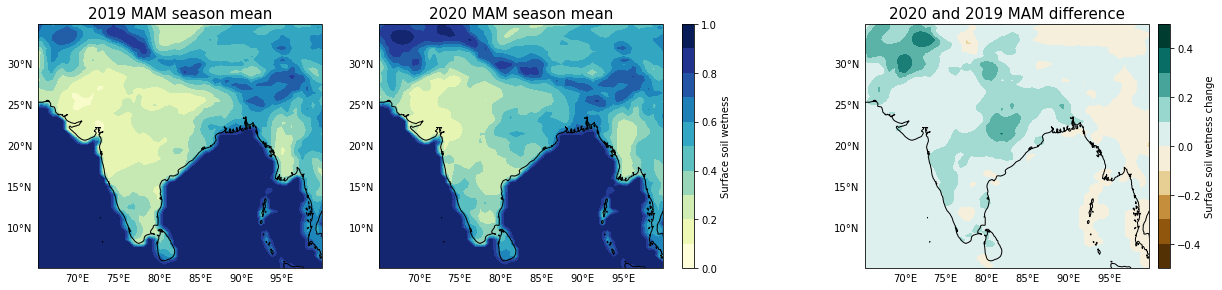

In [119]:
levels = np.arange(0, 1.1, 0.1)
fig, axarr = plt.subplots(1,3, figsize=(21,5), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, surface_soil_wetness_2019_mam.mean(dim='time').to_numpy(), cmap = 'YlGnBu', levels = levels, transform = ccrs.PlateCarree())
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season mean', fontsize=15)

cf1 = axlist[1].contourf(x, y, surface_soil_wetness_2020_mam.mean(dim='time').to_numpy(), cmap = 'YlGnBu', levels = levels, transform = ccrs.PlateCarree())
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season mean', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='YlGnBu'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Surface soil wetness')


levels = np.arange(-0.5, 0.6, 0.1)
cf2 = axlist[2].contourf(x, y, surface_soil_wetness_2020_mam.mean(dim='time').to_numpy() - surface_soil_wetness_2019_mam.mean(dim='time').to_numpy(), cmap = 'BrBG', levels = levels, transform = ccrs.PlateCarree())
# axlist[2].set_xlabel('Longitude', fontsize=13)
# axlist[2].set_ylabel('Latitude', fontsize=13)
axlist[2].set_title('2020 and 2019 MAM difference', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='BrBG'), ax = axlist[2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Surface soil wetness change')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig10.png', dpi=300)

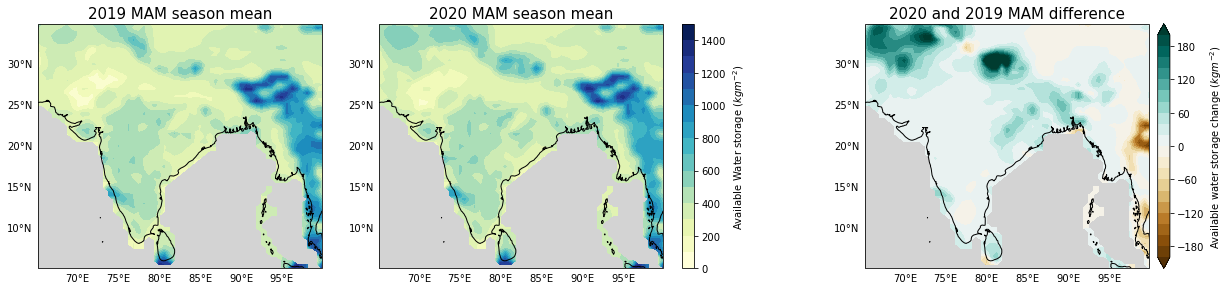

In [127]:
levels = np.arange(0, 1600, 100)
fig, axarr = plt.subplots(1,3, figsize=(21,5), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, available_water_storage_2019_mam.mean(dim='time').to_numpy(), cmap = 'YlGnBu', levels = levels, transform = ccrs.PlateCarree())
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season mean', fontsize=15)

cf1 = axlist[1].contourf(x, y, available_water_storage_2020_mam.mean(dim='time').to_numpy(), cmap = 'YlGnBu', levels = levels, transform = ccrs.PlateCarree())
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season mean', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='YlGnBu'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Available Water storage ($kg m^{-2}$)')


levels = np.arange(-200, 220, 20)
cf2 = axlist[2].contourf(x, y, available_water_storage_2020_mam.mean(dim='time').to_numpy() - available_water_storage_2019_mam.mean(dim='time').to_numpy(), cmap = 'BrBG', levels = levels, transform = ccrs.PlateCarree(), extend = 'both')
# axlist[2].set_xlabel('Longitude', fontsize=13)
# axlist[2].set_ylabel('Latitude', fontsize=13)
axlist[2].set_title('2020 and 2019 MAM difference', fontsize=15)

norm = BM(levels, 256, extend = 'both')
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='BrBG'), ax = axlist[2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Available water storage change ($kg m^{-2}$)')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig11.png', dpi=300)

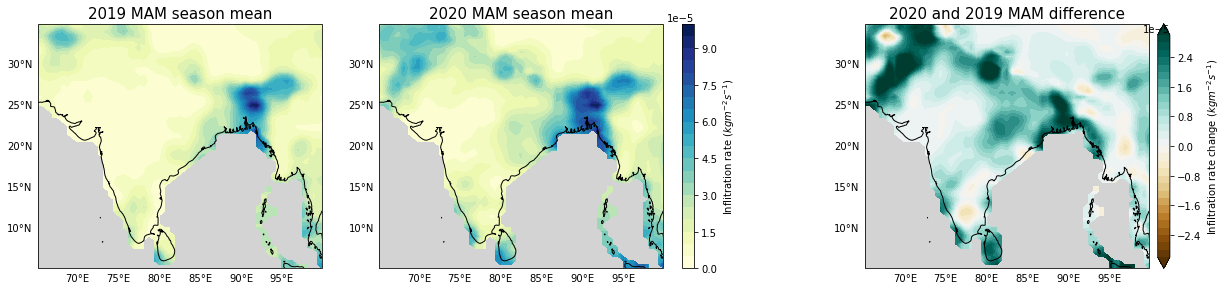

In [134]:
levels = np.arange(0, 10.5, 0.5)*10**(-5)
fig, axarr = plt.subplots(1,3, figsize=(21,5), subplot_kw={'projection':ccrs.PlateCarree()})
axlist = axarr.flatten()

cf0 = axlist[0].contourf(x, y, infil_rate_2019_mam.mean(dim='time').to_numpy(), cmap = 'YlGnBu', levels = levels, transform = ccrs.PlateCarree())
# axlist[0].set_xlabel('Longitude', fontsize=13)
# axlist[0].set_ylabel('Latitude', fontsize=13)
axlist[0].set_title('2019 MAM season mean', fontsize=15)

cf1 = axlist[1].contourf(x, y, infil_rate_2020_mam.mean(dim='time').to_numpy(), cmap = 'YlGnBu', levels = levels, transform = ccrs.PlateCarree())
# axlist[1].set_xlabel('Longitude', fontsize=13)
# axlist[1].set_ylabel('Latitude', fontsize=13)
axlist[1].set_title('2020 MAM season mean', fontsize=15)

norm = BM(levels, 256)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='YlGnBu'), ax = axlist[:2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Inflitration rate ($kg m^{-2} s^{-1}$)')


levels = np.arange(-3, 3.2, 0.2)*10**(-5)
cf2 = axlist[2].contourf(x, y, infil_rate_2020_mam.mean(dim='time').to_numpy() - infil_rate_2019_mam.mean(dim='time').to_numpy(), cmap = 'BrBG', levels = levels, transform = ccrs.PlateCarree(), extend = 'both')
# axlist[2].set_xlabel('Longitude', fontsize=13)
# axlist[2].set_ylabel('Latitude', fontsize=13)
axlist[2].set_title('2020 and 2019 MAM difference', fontsize=15)

norm = BM(levels, 256, extend = 'both')
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap='BrBG'), ax = axlist[2], \
orientation = 'vertical', shrink=0.9, aspect = 20, pad = 0.025, label = 'Infiltration rate change ($kg m^{-2} s^{-1}$)')
# fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, hspace=0., wspace=0.)

for ax in axlist:
    plot_background(ax)

# plt.tight_layout()
plt.savefig('./images/fig12.png', dpi=300)

**The results of the analysis clearly indicate an increase in all three proxies in the lockdown season of 2020. Hence, an improvement in soil fertility owing to lockdown is evident**

####  NDVI analysis was also carried out in the Sundarban region (dense forrest) and Haryana and Punjab (known for agricultural productivity) to determine the impact of CoVID on vegetaion in these regions using satellite imagery.

Data source - the satellite imagery was downloaded from the [USGS Earth Explorer website](https://earthexplorer.usgs.gov/), and we used Landsat-8 Bands 4 (red) and 5 (nir) for the analysis and calculation of NDVI

In [3]:
import rasterio
from rasterio import plot as rplot

In [4]:
import os

In [5]:
os.listdir('./data/USGS/Sundarban/')

['2020', '2019']

In [6]:
test_file = rasterio.open('./data/USGS/Sundarban/2019/LC08_L2SP_137045_20190413_20200829_02_T1_SR_B4.TIF')

In [7]:
test_file.width, test_file.height

(7711, 7871)

In [5]:
def get_bands(location, year):
    filepath = './data/USGS/' + location + f'/{year}'
    try:
        for file in os.listdir(filepath): 
            if 'B4' in file:
                img = rasterio.open(f'{filepath}/{file}')
                red = img.read(1).astype('f4')
            elif 'B5' in file:
                img = rasterio.open(f'{filepath}/{file}')
                nir = img.read(1).astype('f4')
    except FileNotFoundError:
        print('Directory does not exist, try a different directory.')
        print(filepath)
        
    return red, nir

##### Sundarban

In [9]:
sundarban_2019_red, sundarban_2019_nir = get_bands('Sundarban', 2019)
sundarban_2020_red, sundarban_2020_nir = get_bands('Sundarban', 2020)

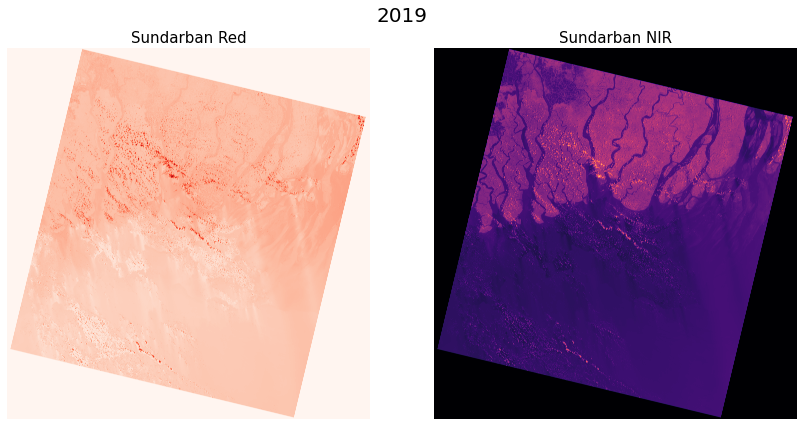

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(sundarban_2019_red, cmap = 'Reds') #red
ax1.axis('off')
ax1.set_title('Sundarban Red', fontsize=15)
ax2.imshow(sundarban_2019_nir, cmap = 'magma') #nir
ax2.axis('off')
ax2.set_title('Sundarban NIR', fontsize=15)
plt.suptitle('2019', fontsize = 20)
fig.tight_layout()

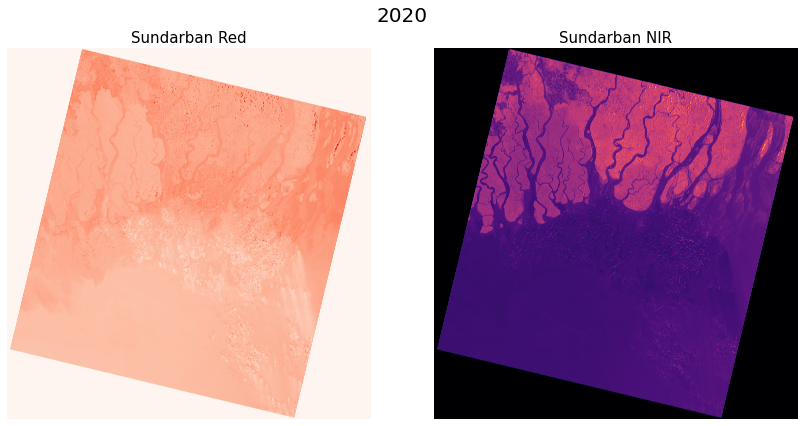

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(sundarban_2020_red, cmap = 'Reds') #red
ax1.axis('off')
ax1.set_title('Sundarban Red', fontsize=15)
ax2.imshow(sundarban_2020_nir, cmap = 'magma') #nir
ax2.axis('off')
ax2.set_title('Sundarban NIR', fontsize=15)
plt.suptitle('2020', fontsize = 20)
fig.tight_layout()

In [6]:
def get_ndvi(red, nir):
    ndvi = np.where((nir + red) == 0., 0, (nir - red)/(nir + red))
    return ndvi

In [13]:
sundarban_2019_ndvi = get_ndvi(sundarban_2019_red, sundarban_2019_nir)
sundarban_2020_ndvi = get_ndvi(sundarban_2020_red, sundarban_2020_nir)

/tmp/ipykernel_45465/508153494.py:2: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.where((nir + red) == 0., 0, (nir - red)/(nir + red))


In [7]:
def save_output(location, source_image, ndvi_val):
    ndviImage = rasterio.open(location, 'w', driver = 'Gtiff', \
                              width = source_image.width, height = source_image.height, \
                              count = 1, crs = source_image.crs, transform = source_image.transform, \
                              dtype = 'float64')
    ndviImage.write(ndvi_val, 1)
    ndviImage.close()

In [20]:
save_output('./data/NDVI_results/sundarban_2019', test_file, sundarban_2019_ndvi)
save_output('./data/NDVI_results/sundarban_2020', test_file, sundarban_2020_ndvi)

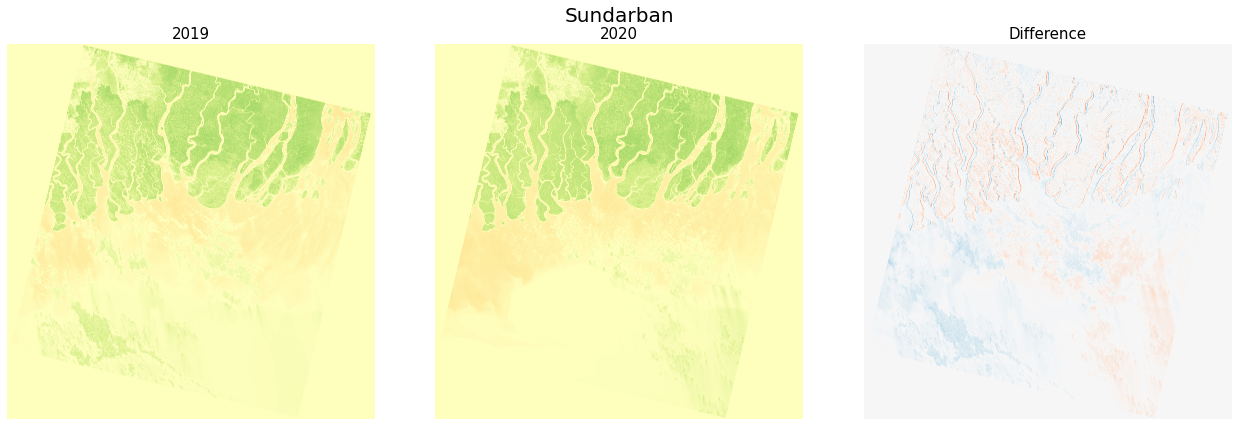

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.imshow(sundarban_2019_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax1.imshow(sundarban_2019_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax1.set_title('2019', fontsize=15)
ax1.axis('off')
ax2.imshow(sundarban_2020_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax2.set_title('2020', fontsize=15)
ax2.axis('off')
ax3.imshow(sundarban_2020_ndvi - sundarban_2019_ndvi[:-10, :], cmap = 'RdBu_r', vmin=-1, vmax=1)
ax3.set_title('Difference', fontsize=15)
ax3.axis('off')
plt.suptitle('Sundarban', fontsize = 20)
fig.tight_layout()
plt.savefig('./images/fig13.png', dpi= 300)

##### Haryana

In [6]:
haryana_2019_red, haryana_2019_nir = get_bands('Haryana', 2019)
haryana_2020_red, haryana_2020_nir = get_bands('Haryana', 2020)

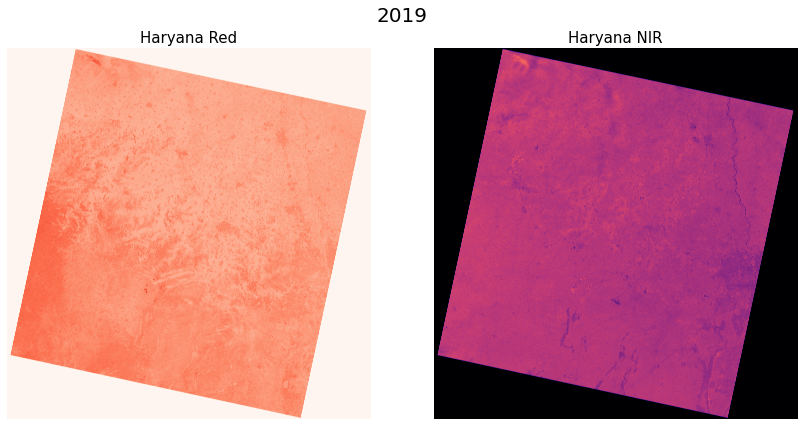

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(haryana_2019_red, cmap = 'Reds') #red
ax1.axis('off')
ax1.set_title('Haryana Red', fontsize=15)
ax2.imshow(haryana_2019_nir, cmap = 'magma') #nir
ax2.axis('off')
ax2.set_title('Haryana NIR', fontsize=15)
plt.suptitle('2019', fontsize = 20)
fig.tight_layout()

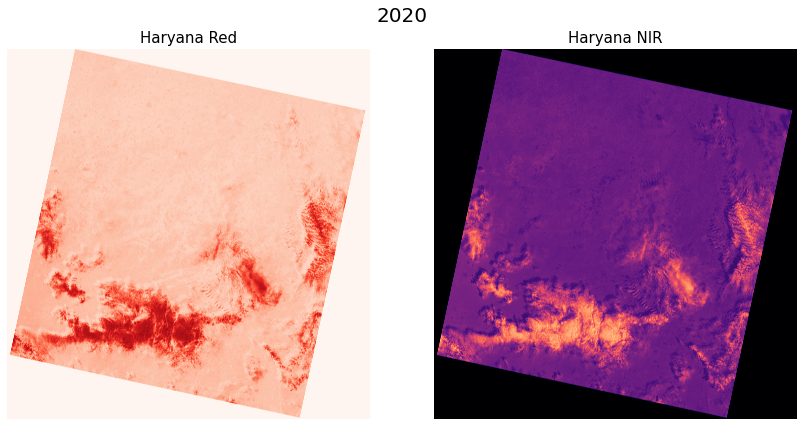

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(haryana_2020_red, cmap = 'Reds') #red
ax1.axis('off')
ax1.set_title('Haryana Red', fontsize=15)
ax2.imshow(haryana_2020_nir, cmap = 'magma') #nir
ax2.axis('off')
ax2.set_title('Haryana NIR', fontsize=15)
plt.suptitle('2020', fontsize = 20)
fig.tight_layout()

In [10]:
haryana_2019_ndvi = get_ndvi(haryana_2019_red, haryana_2019_nir)
haryana_2020_ndvi = get_ndvi(haryana_2020_red, haryana_2020_nir)

/tmp/ipykernel_46094/508153494.py:2: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.where((nir + red) == 0., 0, (nir - red)/(nir + red))


In [14]:
test_file = rasterio.open('./data/USGS/Haryana/2019/LC08_L2SP_147040_20190403_20200829_02_T1_SR_B4.TIF')

In [16]:
save_output('./data/NDVI_results/haryana_2019', test_file, haryana_2019_ndvi)
save_output('./data/NDVI_results/haryana_2020', test_file, haryana_2020_ndvi)

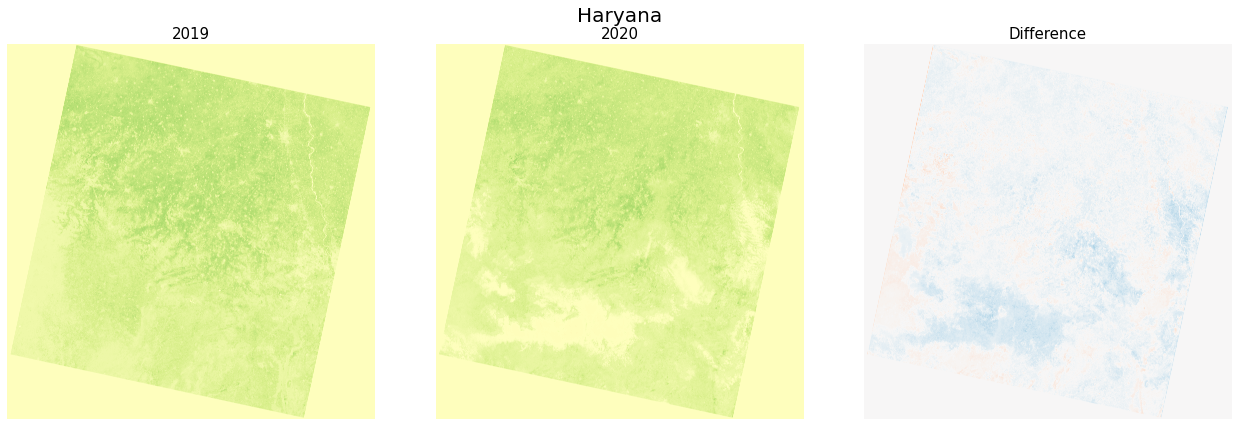

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.imshow(haryana_2019_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax1.imshow(haryana_2019_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax1.set_title('2019', fontsize=15)
ax1.axis('off')
ax2.imshow(haryana_2020_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax2.set_title('2020', fontsize=15)
ax2.axis('off')
ax3.imshow(haryana_2020_ndvi - haryana_2019_ndvi[:, :-10], cmap = 'RdBu_r', vmin=-1, vmax=1)
ax3.set_title('Difference', fontsize=15)
ax3.axis('off')
plt.suptitle('Haryana', fontsize = 20)
fig.tight_layout()
plt.savefig('./images/fig14.png', dpi= 300)

##### Punjab

In [8]:
punjab_2019_red, punjab_2019_nir = get_bands('Punjab', 2019)
punjab_2020_red, punjab_2020_nir = get_bands('Punjab', 2020)

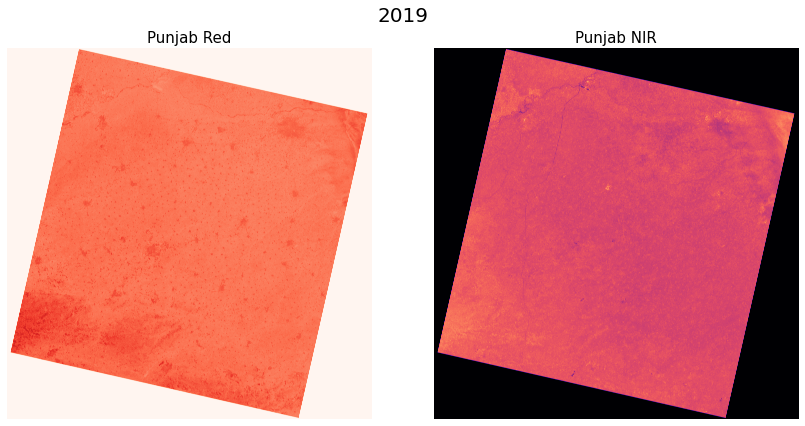

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(punjab_2019_red, cmap = 'Reds') #red
ax1.axis('off')
ax1.set_title('Punjab Red', fontsize=15)
ax2.imshow(punjab_2019_nir, cmap = 'magma') #nir
ax2.axis('off')
ax2.set_title('Punjab NIR', fontsize=15)
plt.suptitle('2019', fontsize = 20)
fig.tight_layout()

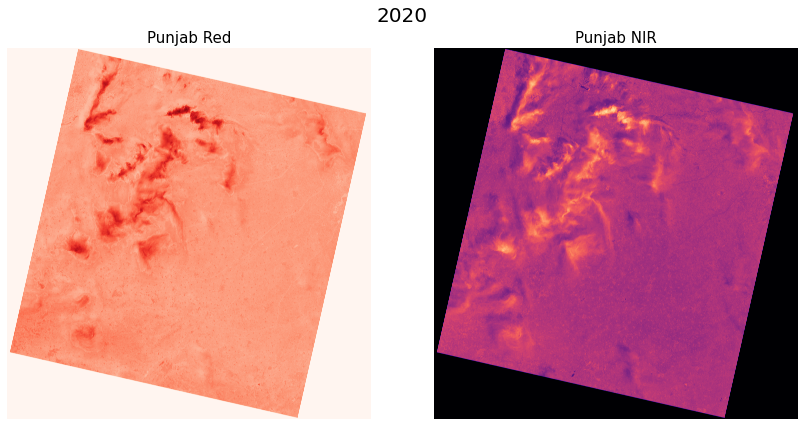

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(punjab_2020_red, cmap = 'Reds') #red
ax1.axis('off')
ax1.set_title('Punjab Red', fontsize=15)
ax2.imshow(punjab_2020_nir, cmap = 'magma') #nir
ax2.axis('off')
ax2.set_title('Punjab NIR', fontsize=15)
plt.suptitle('2020', fontsize = 20)
fig.tight_layout()

In [11]:
punjab_2019_ndvi = get_ndvi(punjab_2019_red, punjab_2019_nir)
punjab_2020_ndvi = get_ndvi(punjab_2020_red, punjab_2020_nir)

/tmp/ipykernel_46715/508153494.py:2: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.where((nir + red) == 0., 0, (nir - red)/(nir + red))


In [12]:
test_file = rasterio.open('./data/USGS/Punjab/2019/LC08_L2SP_148039_20190410_20200828_02_T1_SR_B4.TIF')

In [13]:
save_output('./data/NDVI_results/punjab_2019', test_file, punjab_2019_ndvi)
save_output('./data/NDVI_results/punjab_2020', test_file, punjab_2020_ndvi)

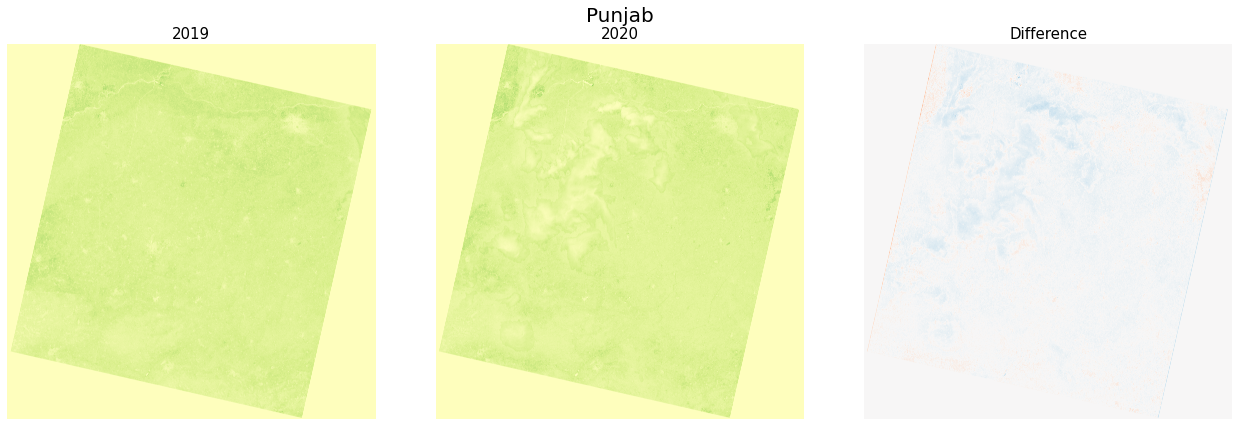

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.imshow(punjab_2019_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax1.imshow(punjab_2019_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax1.set_title('2019', fontsize=15)
ax1.axis('off')
ax2.imshow(punjab_2020_ndvi, cmap = 'RdYlGn', vmin=-1, vmax = 1)
ax2.set_title('2020', fontsize=15)
ax2.axis('off')
ax3.imshow(punjab_2020_ndvi - punjab_2019_ndvi[:, :-10], cmap = 'RdBu_r', vmin=-1, vmax=1)
ax3.set_title('Difference', fontsize=15)
ax3.axis('off')
plt.suptitle('Punjab', fontsize = 20)
fig.tight_layout()
plt.savefig('./images/fig15.png', dpi= 300)

**The results of our analysis compare the 2019 MAM and 2020 MAM seasons and highglight the the Sundarban densely forrested area NDVI increased during lockdown in 2020, while the agricultural lands in Haryana and Punjab actually saw a marginal devline in NDVI**

## The overall results of the analysis

- It is clear that there has been a significant decline in AOD and aerosol concentrations in the Indian subcontinent during and post-lockdown. But, not all pollutant species show a decline such as CO and HCHO.

- Water quality in the Bhagalur region imporoved post-lockdown owing largely to reduced industrial activties. Further analysis over other sectors of Ganga or other rivers can be carried out to further improve the results

- The soil quality and fertility proxies indicate an improvement in soil water storage and infiltration during CoVID lockdown.

- While the vegetation density seems to improve in the dense Sundarban region, the agricultural lands of Haryana and Punjab actually show a decline in NDVI and vegetation density.